In [1]:
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 70.4 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=3446d5ce163059d7ade2b7f2b1de329eb80295548922e97077bfdb52866c7784
  Stored in directory: /root/.cache/pip/wheels/07/00/bc/937e878be0d781a569792a1e0e5acf149e463d4536453ec978
Successfully built asciitree


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import zarr
import pandas as pd

In [3]:
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive',force_remount=True)
os.chdir("/content/drive/My Drive/NASA/Histogram Equalization")
!ls -ltr

Mounted at /content/drive
total 37
-rw------- 1 root root 30828 Mar 21 14:18 wiki.jpg
drwx------ 2 root root  4096 Mar 21 23:43 Tile_1_33
-rw------- 1 root root  1890 Mar 22 00:14 res.png


In [4]:
fname2 = 'Tile_1_33'

rawFileList = os.listdir(fname2)
print (rawFileList)

['Tile_1_33.csv', 'Tile_1_33_s20192192041196.zarr', 'Tile_1_33_s20192200236197.zarr', 'Tile_1_33_s20192210121197.zarr', 'Tile_1_33_s20192210221197.zarr', 'Tile_1_33_s20192192006196.zarr', 'Tile_1_33_s20192201851196.zarr', 'Tile_1_33_s20192200056197.zarr', 'Tile_1_33_s20192210116197.zarr', 'Tile_1_33_s20192201931196.zarr', 'Tile_1_33_s20192192026196.zarr', 'Tile_1_33_s20192182151196.zarr', 'Tile_1_33_s20192181816196.zarr', 'Tile_1_33_s20192191931196.zarr', 'Tile_1_33_s20192191956196.zarr', 'Tile_1_33_s20192182036196.zarr', 'Tile_1_33_s20192191821196.zarr', 'Tile_1_33_s20192181926196.zarr']


In [5]:
dfLabel = pd.read_csv(fname2 + '//' + 'Tile_1_33.csv')
dfLabel['name'] = dfLabel.apply(lambda row: row.scene.split('_')[3], axis=1)
label = dfLabel.loc[dfLabel['name'] == 's20192210221197', 'fire'].iloc[0]
print (label)

0


In [7]:
timeSeriesName = rawFileList[1:]

channel7List = []
channel7Name = []
for name in timeSeriesName:
    channelData = np.array(zarr.open(fname2 + '//' + name)[:, :, 6]) # select channel 7
    channel7List.append(channelData)
    channel7Name.append(name)
    
print (len(channel7List))

17


In [8]:
totalMax = 0
totalMin = 10
for i in range(len(channel7List)):
    mat = channel7List[i]
    tempMax, tempMin = np.max(mat), np.min(mat)
    if tempMax > totalMax:
        print (i)
        totalMax = tempMax
    if tempMin < totalMin:
        totalMin = tempMin

print (totalMax)
print (totalMin)

0
1
6
8.337935447692871
0.03592449799180031


[[22 22 22 ... 23 23 22]
 [21 22 23 ... 24 24 24]
 [20 21 22 ... 25 25 25]
 ...
 [28 27 25 ... 37 35 32]
 [26 28 27 ... 35 35 33]
 [28 27 28 ... 34 35 34]]


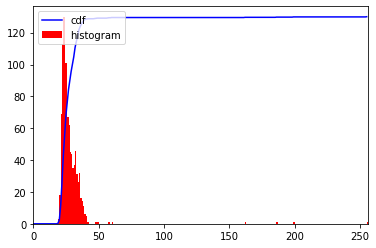

In [22]:
arr = channel7List[6]
arrNormalized = (arr-totalMin)/(totalMax-totalMin)
img = np.array(arrNormalized * 255, dtype = np.uint8)

print (img)

hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

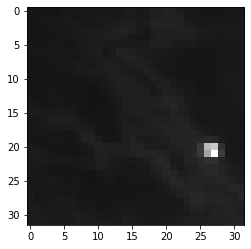

In [23]:
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

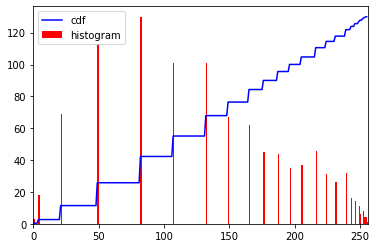

In [24]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[img]

hist,bins = np.histogram(img2.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

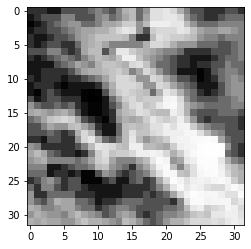

In [25]:
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.show()

[48 52 46 37 32 29 28 31 35 40 50 46 42 44 47 50 51 52 51 54 46 39 48 55
 57 70 86 70 36 31 30 29]


[]

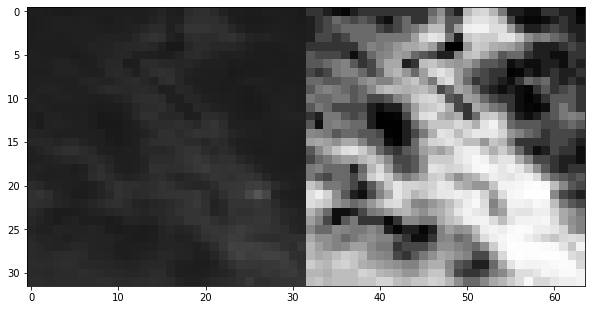

In [14]:
arr = channel7List[0]
arrNormalized = (arr-totalMin)/(totalMax-totalMin)
img = np.array(arrNormalized * 255, dtype = np.uint8)

print (img[21,:])

equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side

plt.figure(figsize=(10,6))
plt.imshow(res, cmap='gray', vmin=0, vmax=255)
plt.plot()
#cv2.imwrite('res.png',res)
